# This notebook uses the raster maginalized model (Okun et al. 2012, 2015) to generate a raster of neural responses, constrained by three properties of the observed raster of neural response:
1) the generated raster has the same mean firing rate for each cell as the original raster
2) the generated raster has the same overall population rate as the original raster
3) the generated raster has the same population coupling for each cell as the original raster

Note that it's not always possible to generate such a raster. In this case, an error message is given.

# Then the pairwise correlation coefficients are calculated, and plotted for the original raster and the generated raster.

# The main goal here is to determine whether these pairwise correlations are similar. If they are, this means that the three constraints used to generate the raster also capture pairwise correlations.
This is because the model generated data doesn't have access to the pairwise correlations, apriori. So if this generated data can capture pairwise correlations, it means that the imposed constraints (firing rate, population rate, population coupling) implicitly impose pairwise correlations. Another way of sayign this is that population coupling contains pairwise correlation data.

#To check that it's the last constraint of population coupling, and not the first two constraints from the list above, that capture pairwise correlations, we will also generate a raster that meets only first two constraints. We will again compare the pairwise population matrices for this generated data and the real data. 
The expectation is that the data generated from all three constraints will have similar pairwise correlations to the real data, but that the data generated from just the first two constraints will have less similar pairise correlations.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import synthetic_signals
import Okun_Shuffle
import generate_RMM



:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Import some synthetic data, play around with firing rate and  number of cells.


In [4]:

# Get raster by creating a synthetic spike train. This is useful for checking effect of firing rate, correlation on popcorr. 
    #But otherwise it has no inherent structure to it, so you're better off using Okun's raster below.
t_start=0
t_end = 10000 #in microseconds
n_cells = 50
firing_rate= 10 # in spikes per second
spike_times, cell_ids = synthetic_signals.generate_poisson_spike_train_population(n_cells, firing_rate,
                                                                               correlation=6 * 0.08,
                                                                               t_start=t_start,
                                                                               t_stop=t_end,
                                                                               seed=1 + 1000)

# #now make a binned (1 ms) and binarized raster to use for the shuffling
raster_original = Okun_Shuffle.make_raster(spike_times, cell_ids, n_cells, t_start,t_end, dt_conv=1.0)
raster=raster_original.copy()


print "the mean firing rate is " + np.str(np.mean(np.sum(raster,axis=0) /(t_end/1000) ))

the mean firing rate is 9.746


# Import raster provided by Okun (I think it's real data). 10 cells, ~5 minutes, mea firing rate ~20 Hz.

In [5]:
#2) Use the raster provided by Michael Okun (I think it's real data) with his sample code
#(note that this requires raster.mat to be in your working directory)

t_end = 5*60*1000 # in ms, total time of raster
import h5py
f = h5py.File('raster.mat','r') #load mat file
variables = f.items()
for var in variables:
    name = var[0]
    data = var[1]
    if type(data) is h5py.Dataset:
        raster_big = data.value

raster = raster_big[:,:]

print "the mean firing rate is " + np.str(np.mean(np.sum(raster,axis=0) /(t_end/1000) ))

the mean firing rate is 23.6


# Import extracted spikes from Observatory Calcium Data


In [7]:
#For now, we'll use the spikes Anatoly extracted from session B. He already binarized them (into 33 ms bins, since the calcium
#imaging sampling rate is 30 Hz)
#this raster contains responses from 242 neurons for an hour (64 minutes of data, for the whole session B)
#we'll use smaller chunks of time

t_end_frame=30*1200 #%10 seconds of data
t_end = t_end_frame*(33) # in ms, total time of raster
import h5py
f = h5py.File('observatory_raster.mat','r') #load mat file
variables = f.items()
for var in variables:
    name = var[0]
    data = var[1]
    if type(data) is h5py.Dataset:
        raster_big = data.value

        
raster = raster_big.T[:t_end_frame,:20]
print np.shape(raster_big)
print np.shape(raster)

print "the mean firing rate is " + np.str(np.mean(np.sum(raster,axis=0) /(t_end/1000) ))

(242L, 115730L)
(36000L, 20L)
the mean firing rate is 0.286658249158


Generate a new raster ('raster_model_wcoupling') that matches the constraints of the original raster. 
Then check to see that it meets the constraints. During this process, we'll also generate a raster that matches just the first two constraints (raster_model).


In [8]:
raster_model, raster_model_wcoupling = generate_RMM.get_cRMM_raster(raster)

constraints_met = generate_RMM.check_constraints(raster,raster_model)
constraints_met_wcoupling = generate_RMM.check_constraints(raster,raster_model_wcoupling)


Only the first two constraints match (firing rate and population rate).
All three constraints match.


Calculate pairwise correlation coefficients for both the original and the two generated raster. The 'sortby' optional flag indicateswhether the matrices should be row-sorted by each cell's population coupling. The default is that they should be sorted (as done in Okun et al. 2015), since this allows easy visual verification that:
1) cells with high population couplin also have high pairwise population coefficients
2) pairwise population coefficients for generated data are similar to those for real data

In [9]:
pairwise_data,pairwise_model_wcoupling = generate_RMM.get_pairwise(raster,raster_model_wcoupling,sortby=1)
pairwise_data,pairwise_model = generate_RMM.get_pairwise(raster,raster_model,sortby=1)


Plot the pairwise correlation coefficients for the model generated raster on the lower triangle, and the coefficients for the data on the upper triangle. This will reproduce Fig. 2B and 2D of Okun et al. 2015. Keep in mind that if the 'sortby' flag was set to 1 above, the rows will be sorted in descending population coupling order. So if everything checks out, cells near the top of the diagonal will have both high pairwise corre values (redder colors) and high coupling values!

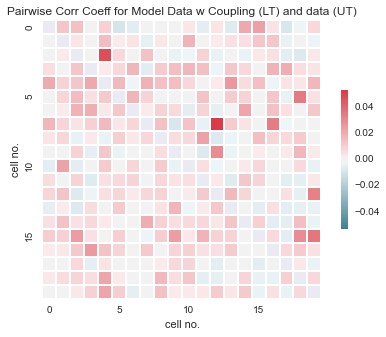

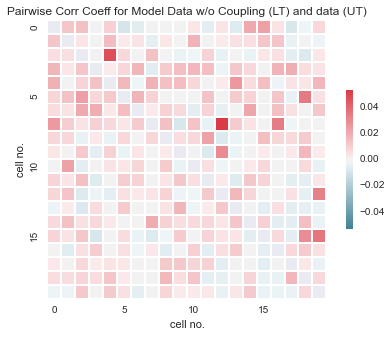

In [10]:
#this is equivalent to Fig 2D (Okun et al. 2015)
vmaxc=0.3 #colormap max
vminc=-0.1
#colormap min

titlestr="Pairwise Corr Coeff for Model Data w Coupling (LT) and data (UT)"
generate_RMM.plot_pairwise(pairwise_data,pairwise_model_wcoupling,titlestr)


#this is equivalent to Fig 2D (Okun et al. 2015)
titlestr="Pairwise Corr Coeff for Model Data w/o Coupling (LT) and data (UT)"
generate_RMM.plot_pairwise(pairwise_data,pairwise_model,titlestr)